# Ray Tune Test
Ray tune is a hyperparameter tuning library. Trying to figure out how this works

## Issues
1. How do I set which GPU to use? Disabled my GPU choosing code to make this run(Uncomment that thing in model_train later!). 
2. Trials are somehow limited to only 3? And then it just stops. How to make it do more tries.
3. We can make ray tune run trials in parallel. (With fractional GPUs, more CPUs etc.) Maybe explore
4. using the tune.report() reports the results and will be used to early stop training. Currently, I only report at the very end. Which is not ideal. Modify to report at each stage!

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, create_perceptron_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_summed_sim_data_equidistance_detector_extended.pkl')
equidistance_detector_normalization(data)

data = data[data["Wave Int"] == 2.0]    # Keep only 1 wavelength
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log

# From long to wide
data = pd.pivot(data, index=['Wave Int', 'Uterus Thickness', 'Maternal Wall Thickness', "Maternal Mu_a", "Fetal Mu_a"], columns="SDD", values="Intensity").reset_index()
# Since SDD's have integer values, the columns get integer names - > which can't be accessed -> str conversion
data.columns = [str(X) for X in data.columns]   
x_columns = list(filter(lambda X: X.isdigit(), data.columns))


# fitting_param_table = get_interpolate_fit_params_custom(data, exponenet_4, weights=[1, 0])
# x_columns = list(filter(lambda X: 'alpha' in X, fitting_param_table.columns))
y_columns = ["Maternal Wall Thickness"]
# filtered_fitting_param_table = fitting_param_table[fitting_param_table['Wave Int'] == 2.0]
# x_scaler = preprocessing.StandardScaler()
# filtered_fitting_param_table[fitting_param_columns] = x_scaler.fit_transform(filtered_fitting_param_table[fitting_param_columns])
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])
# filtered_fitting_param_table[y_columns] = y_scaler.fit_transform(filtered_fitting_param_table[y_columns])

In [3]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [20.]
Y scale var [120.]


In [9]:
def train_model2(config, epoch=100):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
    model = create_perceptron_model(config['model'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)
    tune.report(train_loss=train_loss[-1], val_loss=val_loss[-1])

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

config = {
    "lr" : tune.loguniform(1e-4, 1e-1),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([64, 32, 16, 8, 4]),
    "model": tune.choice([[20, 10, 1], [20, 10, 5, 1], [20, 16, 8, 4, 2, 1], [20, 8, 2, 1]]),
    "momentum": tune.choice([0.7, 0.8, 0.9, 1.0]),
}
scheduler = ASHAScheduler(metric="val_loss", mode="min", max_t=10, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "training_iteration"])
result = tune.run(train_model2, config=config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=100, resources_per_trial={"cpu": 2, "gpu": 0.5},)

best_trial = result.get_best_trial("train_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


== Status ==
Current time: 2023-05-22 14:33:14 (running for 00:00:00.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 10.000: None | Iter 5.000: None
Logical resource usage: 2.0/64 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-05-22_14-33-14
Number of trials: 70/100 (69 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+----------------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr | model                |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+----------------------+------------|
| train_model2_41ed8_00000 | RUNNING  | 169.237.32.34:3794888 |            4 | 0.00140675  | [20, 10, 1]          |        1   |
| train_model2_41ed8_00001 | PENDING  |                       |            4 | 0.000129955 | [20, 16, 8, 4, 2, 1] |        0.7 

Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_41ed8_00000,2023-05-22_14-33-24,True,blueberry,10,169.237.32.34,3794888,9.13482,0.744608,9.13482,1684791204,1.15124,10,41ed8_00000,0.0707056
train_model2_41ed8_00001,2023-05-22_14-33-22,True,blueberry,5,169.237.32.34,3794945,5.78038,0.871573,5.78038,1684791202,0.640936,5,41ed8_00001,1.09893
train_model2_41ed8_00002,2023-05-22_14-33-29,True,blueberry,5,169.237.32.34,3798662,4.65364,0.70344,4.65364,1684791209,0.641605,5,41ed8_00002,1.05295
train_model2_41ed8_00003,2023-05-22_14-33-33,True,blueberry,10,169.237.32.34,3799125,6.95804,0.54716,6.95804,1684791213,1.04419,10,41ed8_00003,0.25841
train_model2_41ed8_00004,2023-05-22_14-33-37,True,blueberry,10,169.237.32.34,3801214,7.19929,0.549919,7.19929,1684791217,0.351409,10,41ed8_00004,0.218246
train_model2_41ed8_00005,2023-05-22_14-33-39,True,blueberry,5,169.237.32.34,3804380,3.88866,0.484913,3.88866,1684791219,0.643843,5,41ed8_00005,1.22248
train_model2_41ed8_00006,2023-05-22_14-33-44,True,blueberry,5,169.237.32.34,3806729,4.63215,0.640912,4.63215,1684791224,0.642899,5,41ed8_00006,1.13205
train_model2_41ed8_00007,2023-05-22_14-33-45,True,blueberry,5,169.237.32.34,3807480,4.23371,0.544014,4.23371,1684791225,0.643809,5,41ed8_00007,1.20091
train_model2_41ed8_00008,2023-05-22_14-33-53,True,blueberry,10,169.237.32.34,3809574,7.40141,0.585973,7.40141,1684791233,0.290022,10,41ed8_00008,0.118945
train_model2_41ed8_00009,2023-05-22_14-33-54,True,blueberry,10,169.237.32.34,3810307,6.42284,0.490474,6.42284,1684791234,0.2301,10,41ed8_00009,0.0585646


== Status ==
Current time: 2023-05-22 14:33:19 (running for 00:00:05.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-05-22_14-33-14
Number of trials: 72/100 (70 PENDING, 2 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+----------------------+------------+--------------+------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr | model                |   momentum |   train_loss |   val_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+----------------------+------------+--------------+------------+----------------------|
| train_model2_41ed8_00000 | RUNNING  | 169.237.32.34:3794888 |            4 | 0.00140675  | [20, 10, 1

2023-05-22 14:39:54,957	INFO tune.py:945 -- Total run time: 400.91 seconds (400.89 seconds for the tuning loop).


== Status ==
Current time: 2023-05-22 14:39:54 (running for 00:06:40.89)
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 10.000: -0.21824618726968764 | Iter 5.000: -1.1062730446457862
Logical resource usage: 0/64 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-05-22_14-33-14
Number of trials: 100/100 (100 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+----------------------+------------+--------------+----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr | model                |   momentum |   train_loss |       val_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+----------------------+------------+--------------+----------------+----------------------|
| train_model2_41ed8_00000 | TERMINATED | 169.237.32.34:379488

Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064

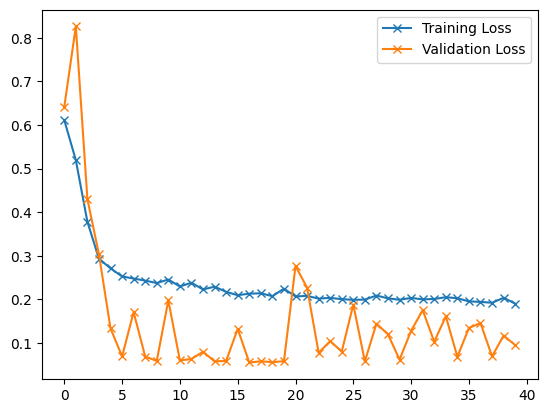

In [6]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 16, 'shuffle': True, 'num_workers': 2
}
train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
model = create_perceptron_model([20, 8, 2, 1])
criterion = nn.MSELoss()
# optimizer = Adam(model.parameters(), lr=0.1)
optimizer = SGD(model.parameters(), lr=0.00076, momentum=0.8)
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=40)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
plt.legend()